# ACCENT CLASSIFICATION
LR Modle , mandarin, russia, and spanish.


In [1]:
# ============================================================
# @title 1. Mount Google Drive
# ============================================================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# ============================================================
# @title 2. Install Required Packages
# ============================================================
!pip install librosa -q
!pip install statsmodels -q


In [3]:
# ============================================================
# @title 3. Add Module Path and Import
# ============================================================
import sys
sys.path.append('/content/drive/MyDrive/Fall25/EE502/FinalProjects/Ch24')

# Import all functions from our module
from accent_classification import *

# Also import additional libraries we'll need
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
# ============================================================
# @title 4. Setup and Configuration
# ============================================================
# Setup plotting style
setup_plotting_style()

# Set random seed for reproducibility
set_seed(config.RANDOM_STATE)

# Print configuration
print("=" * 60)
print("ACCENT CLASSIFICATION")
print("=" * 60)
print(f"\n Data directory: {config.DATA_DIR}")
print(f" Target accents: {config.TARGET_ACCENTS}")
print(f" Sample rate: {config.SAMPLE_RATE} Hz")
print(f" Features: {config.N_MFCC} MFCCs, {config.N_CHROMA} Chroma, etc.")
print(f" Test size: {config.TEST_SIZE}, Val size: {config.VAL_SIZE}")
print(f" Random seed: {config.RANDOM_STATE}")
print("=" * 60)


ACCENT CLASSIFICATION

 Data directory: /content/drive/MyDrive/Fall25/EE502/FinalProjects/Ch24/data
 Target accents: ['mandarin', 'russian', 'spanish']
 Sample rate: 16000 Hz
 Features: 40 MFCCs, 12 Chroma, etc.
 Test size: 0.15, Val size: 0.15
 Random seed: 42


In [5]:
# ============================================================
# @title 5. Load Data and Create Splits
# ============================================================
print("\n" + "=" * 60)
print("STEP 1: LOADING DATA")
print("=" * 60)

# Load metadata
df = load_metadata(config.DATA_DIR, config.TARGET_ACCENTS)

# Create train/val/test splits
train_df, val_df, test_df = create_splits(
    df, config.TEST_SIZE, config.VAL_SIZE, config.RANDOM_STATE
)

# Get split information
split_info = get_split_info(train_df, val_df, test_df)



STEP 1: LOADING DATA
Found 157 files for mandarin
Found 82 files for russian
Found 243 files for spanish

Loaded 482 total samples for accents: ['mandarin', 'russian', 'spanish']
Distribution: {'spanish': 243, 'mandarin': 157, 'russian': 82}

Data splits created:
  Train: 336 samples
  Val:   73 samples
  Test:  73 samples


In [6]:
# ============================================================
# @title 6. Extract Features (with Caching)
# ============================================================
print("\n" + "=" * 60)
print("STEP 2: FEATURE EXTRACTION")
print("=" * 60)

# Extract features for training set
X_train, y_train = extract_features_batch(
    train_df,
    config,
    cache_path=f"{config.CACHE_DIR}/features_train.pkl"
)

# Extract features for validation set
X_val, y_val = extract_features_batch(
    val_df,
    config,
    cache_path=f"{config.CACHE_DIR}/features_val.pkl"
)

# Extract features for test set
X_test, y_test = extract_features_batch(
    test_df,
    config,
    cache_path=f"{config.CACHE_DIR}/features_test.pkl"
)

# Print feature info
print("\n Feature Statistics:")
feature_info = get_feature_info(X_train)
for key, value in feature_info.items():
    print(f"  {key}: {value}")



STEP 2: FEATURE EXTRACTION
 Loading features from cache: /content/drive/MyDrive/Fall25/EE502/FinalProjects/Ch24/accent_classification/cache/features_train.pkl
 Loading features from cache: /content/drive/MyDrive/Fall25/EE502/FinalProjects/Ch24/accent_classification/cache/features_val.pkl
 Loading features from cache: /content/drive/MyDrive/Fall25/EE502/FinalProjects/Ch24/accent_classification/cache/features_test.pkl

 Feature Statistics:
  n_samples: 336
  n_features: 298
  feature_range: (-418.2132263183594, 5665.51018370607)
  feature_mean: 31.732597802203593
  feature_std: 280.5737212795528


In [7]:
# ============================================================
# @title 7. Preprocessing
# ============================================================
print("\n" + "=" * 60)
print("STEP 3: PREPROCESSING")
print("=" * 60)

# 1. Data augmentation (training set only)
X_train_aug, y_train_aug = augment_data(X_train, y_train, config)

# 2. Standardization (fit on training, transform val/test)
X_train_scaled, X_val_scaled, X_test_scaled, scaler = standardize_features(
    X_train_aug, X_val, X_test
)

# 3. Feature selection - find best k
feature_selection_results = find_best_k(
    X_train_scaled, y_train_aug,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    config.FEATURE_SELECTION_K_VALUES,
    config
)

best_k = feature_selection_results['best_k']

# 4. Apply best k to get final feature sets
X_train_final, X_val_final, X_test_final, selector = select_features(
    X_train_scaled, y_train_aug, X_val_scaled, X_test_scaled, best_k
)

print(f"\n Final feature shape: {X_train_final.shape}")



STEP 3: PREPROCESSING
 Augmented data: 336 → 672 samples
 Features standardized (mean=0, std=1)

 Testing feature selection with k values: [10, 11, 12, 13, 14]
  k=10: Val F1=0.3725, Test F1=0.3879
  k=11: Val F1=0.4030, Test F1=0.3905
  k=12: Val F1=0.4106, Test F1=0.3711
  k=13: Val F1=0.3879, Test F1=0.4252
  k=14: Val F1=0.3559, Test F1=0.4896
 Best k: 12 (Val F1: 0.4106)

 Final feature shape: (672, 12)


In [8]:
# ============================================================
# @title 8. Train Models
# ============================================================
print("\n" + "=" * 60)
print("STEP 4: MODEL TRAINING")
print("=" * 60)

# Train Logistic Regression
lr_result = train_logistic_regression(
    X_train_final, y_train_aug, X_val_final, y_val, config
)

# Train Bagging Ensemble
bagging_result = train_bagging_ensemble(
    X_train_final, y_train_aug, X_val_final, y_val, config
)



STEP 4: MODEL TRAINING

 Training Logistic Regression with Grid Search...
  Best C: 10.0
  Train F1: 0.4706
  Val F1: 0.3958

 Training Bagging Ensemble...
  N estimators: 50
  Train F1: 0.4719
  Val F1: 0.3895


In [9]:
# ============================================================
# @title 9. Select Best Model
# ============================================================
print("\n" + "=" * 60)
print("STEP 5: MODEL SELECTION")
print("=" * 60)

# Combine all models
all_models = [lr_result, bagging_result]

# Select best based on test performance
selection_result = select_best_model(all_models, X_test_final, y_test)

# Get the best model
best_model = selection_result['best_model']['model']
best_model_name = selection_result['best_model']['name']



STEP 5: MODEL SELECTION

 Evaluating models on test set...
  Logistic Regression (L2): Test F1=0.4191, Accuracy=0.5205
  Bagging Ensemble: Test F1=0.4517, Accuracy=0.5342

 Best model: Bagging Ensemble (Test F1: 0.4517)


In [10]:
# ============================================================
# @title 10. Full Evaluation
# ============================================================
print("\n" + "=" * 60)
print("STEP 6: EVALUATION")
print("=" * 60)

# Evaluate best model
results = evaluate_model_full(
    best_model, X_test_final, y_test, config.TARGET_ACCENTS
)

print(f"\n Best Model: {best_model_name}")
print(f" Test Accuracy: {results['accuracy']:.4f}")
print(f" Test Macro F1: {results['macro_f1']:.4f}")
print(f"\n Per-Accent F1 Scores:")
for accent, f1 in results['per_accent_f1'].items():
    print(f"  {accent.capitalize()}: {f1:.4f}")

print(f"\n Classification Report:")
print(results['classification_report'])



STEP 6: EVALUATION

 Best Model: Bagging Ensemble
 Test Accuracy: 0.5342
 Test Macro F1: 0.4517

 Per-Accent F1 Scores:
  Mandarin: 0.7027
  Russian: 0.2857
  Spanish: 0.7869

 Classification Report:
              precision    recall  f1-score   support

    mandarin       0.54      0.54      0.54        24
     russian       0.20      0.17      0.18        12
     spanish       0.62      0.65      0.63        37

    accuracy                           0.53        73
   macro avg       0.45      0.45      0.45        73
weighted avg       0.52      0.53      0.53        73



In [11]:
# ============================================================
# @title 11. Benchmark Comparison
# ============================================================
print("\n" + "=" * 60)
print("STEP 7: BENCHMARK COMPARISON")
print("=" * 60)

# Train benchmark model (Linear SVM)
print("Training benchmark (Linear SVM)...")
benchmark = LinearSVC(random_state=config.RANDOM_STATE, max_iter=2000)
benchmark.fit(X_train_final, y_train_aug)

# Compare to benchmark
comparison = compare_to_benchmark(
    best_model, X_test_final, y_test, benchmark, config.TARGET_ACCENTS
)

print(f"\n Calc Model ({best_model_name}):")
print(f"  F1 Score: {comparison['Calc_f1']:.4f}")
print(f"  Accuracy: {comparison['Calc_accuracy']:.4f}")

print(f"\n Benchmark (Linear SVM):")
print(f"  F1 Score: {comparison['benchmark_f1']:.4f}")
print(f"  Accuracy: {comparison['benchmark_accuracy']:.4f}")

print(f"\n Improvement:")
print(f"  F1: {comparison['f1_improvement']:+.4f}")
print(f"  Accuracy: {comparison['accuracy_improvement']:+.4f}")

print(f"\n Statistical Test (McNemar's):")
print(f"  P-value: {comparison['mcnemar']['p_value']:.4f}")
print(f"  Significant difference: {comparison['mcnemar']['significant']}")



STEP 7: BENCHMARK COMPARISON
Training benchmark (Linear SVM)...

 Calc Model (Bagging Ensemble):
  F1 Score: 0.4517
  Accuracy: 0.5342

 Benchmark (Linear SVM):
  F1 Score: 0.3927
  Accuracy: 0.5342

 Improvement:
  F1: +0.0589
  Accuracy: +0.0000

 Statistical Test (McNemar's):
  P-value: 1.0000
  Significant difference: False



STEP 8: VISUALIZATIONS


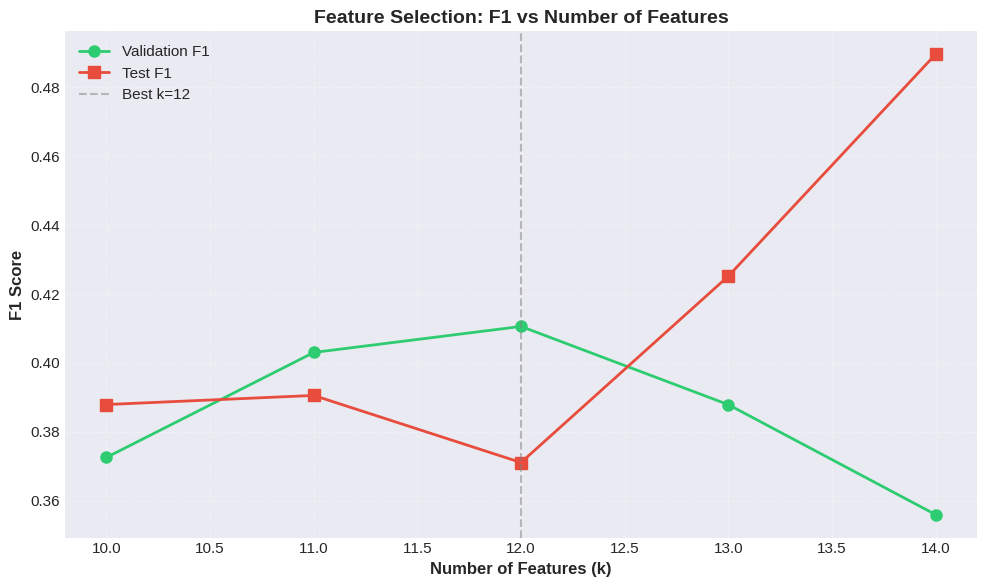

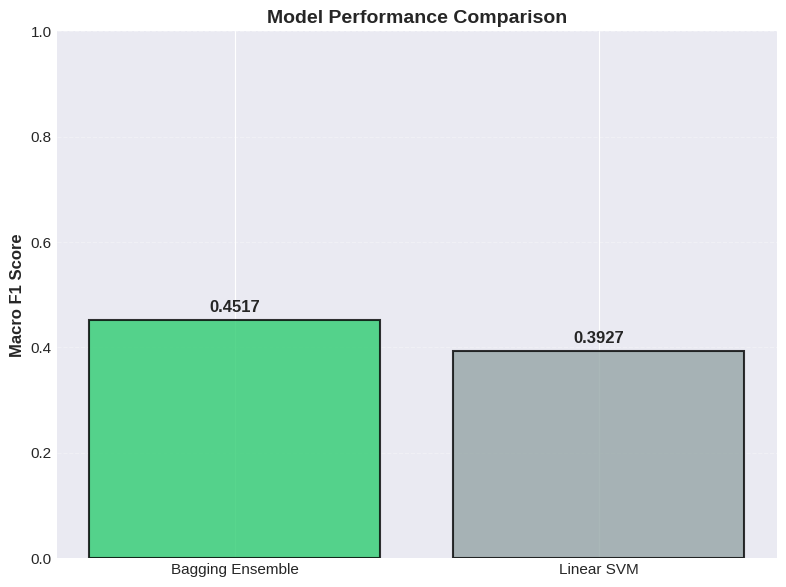

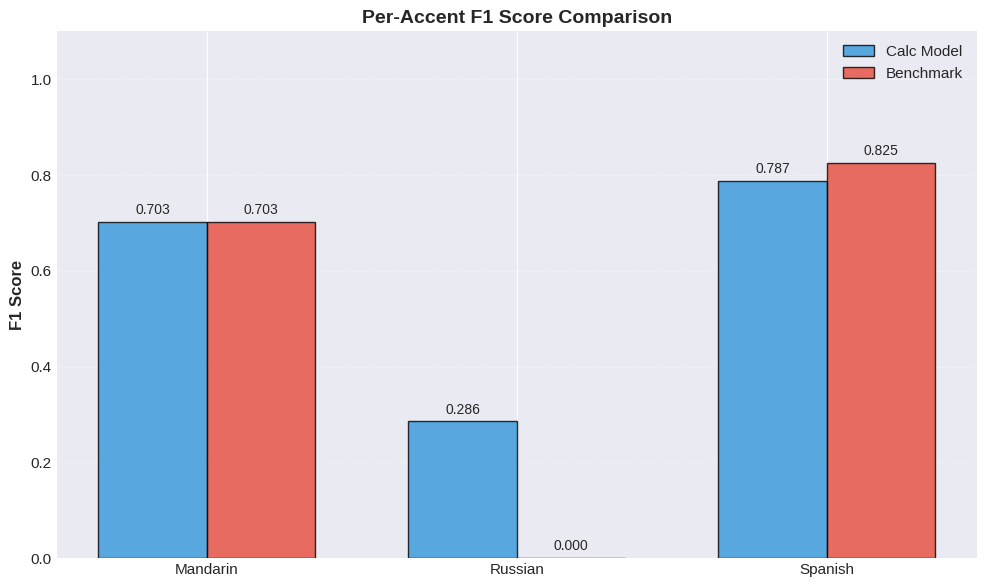

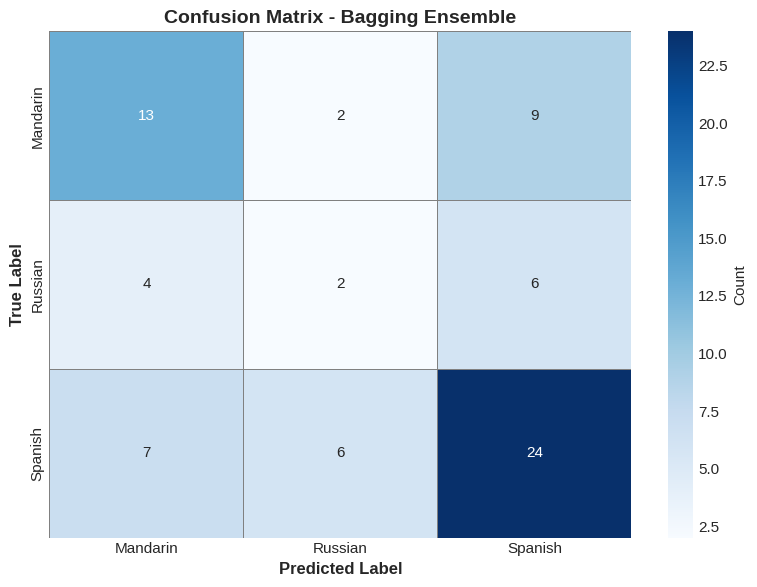

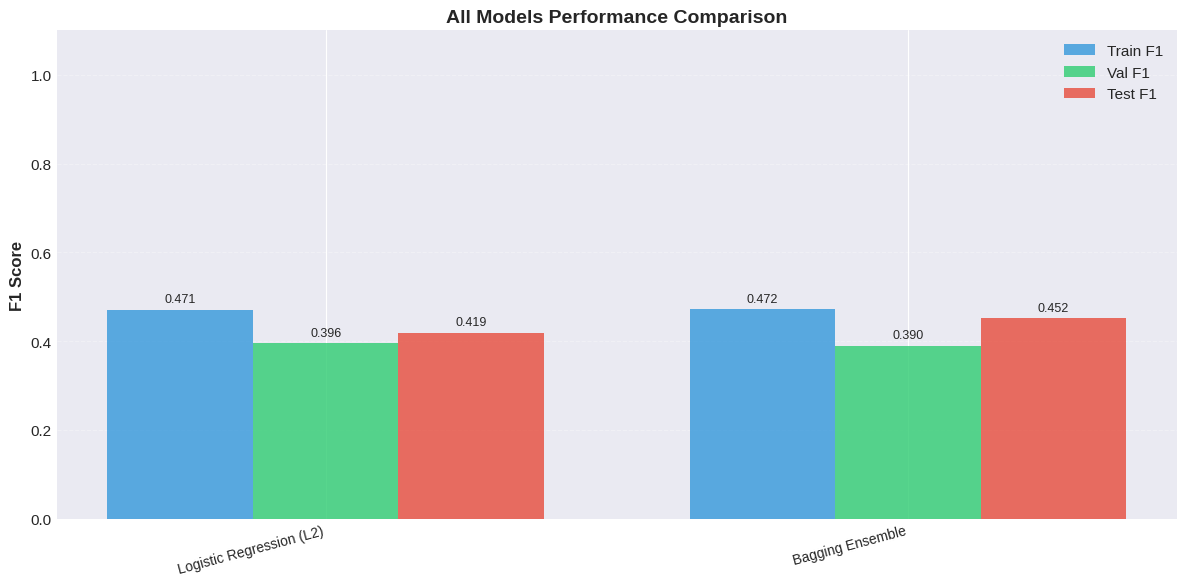

In [12]:
# ============================================================
# @title 12. Visualizations
# ============================================================
print("\n" + "=" * 60)
print("STEP 8: VISUALIZATIONS")
print("=" * 60)

# Plot 1: Feature Selection Results
fig1 = plot_feature_selection_results(feature_selection_results['all_results'])
plt.show()

# Plot 2: Benchmark Comparison
fig2 = plot_benchmark_comparison(
    comparison['Calc_f1'],
    comparison['benchmark_f1'],
    best_model_name,
    'Linear SVM'
)
plt.show()

# Plot 3: Per-Accent F1 Comparison
fig3 = plot_per_accent_f1(
    comparison['Calc_per_accent_f1'],
    comparison['benchmark_per_accent_f1'],
    config.TARGET_ACCENTS
)
plt.show()

# Plot 4: Confusion Matrix
fig4 = plot_confusion_matrix(
    results['confusion_matrix'],
    config.TARGET_ACCENTS,
    title=f'Confusion Matrix - {best_model_name}'
)
plt.show()

# Plot 5: All Models Comparison
fig5 = plot_all_models_comparison(selection_result['all_results'])
plt.show()


In [13]:
# ============================================================
# @title 13. Save Results
# ============================================================
print("\n" + "=" * 60)
print("STEP 9: SAVING RESULTS")
print("=" * 60)

# Prepare final results dictionary
final_results = {
    'experiment_config': config.to_dict(),
    'data_splits': split_info,
    'feature_selection': {
        'best_k': best_k,
        'best_val_f1': feature_selection_results['best_val_f1'],
        'all_k_results': feature_selection_results['all_results'],
    },
    'best_model': {
        'name': best_model_name,
        'params': selection_result['best_model']['best_params'],
        'train_f1': selection_result['best_model']['train_f1'],
        'val_f1': selection_result['best_model']['val_f1'],
        'test_f1': selection_result['best_model']['test_f1'],
        'test_accuracy': selection_result['best_model']['test_accuracy'],
    },
    'all_models': selection_result['all_results'],
    'evaluation': {
        'accuracy': results['accuracy'],
        'macro_f1': results['macro_f1'],
        'weighted_f1': results['weighted_f1'],
        'per_accent_f1': results['per_accent_f1'],
        'confusion_matrix': results['confusion_matrix'].tolist(),
    },
    'benchmark_comparison': {
        'Calc_f1': comparison['Calc_f1'],
        'benchmark_f1': comparison['benchmark_f1'],
        'improvement': comparison['f1_improvement'],
        'beats_benchmark': comparison['beats_benchmark'],
        'mcnemar_test': comparison['mcnemar'],
    }
}

# Save to JSON
save_results(final_results, f"{config.RESULTS_DIR}/final_results.json")



STEP 9: SAVING RESULTS
 Results saved to: /content/drive/MyDrive/Fall25/EE502/FinalProjects/Ch24/accent_classification/results/final_results.json


In [14]:
# ============================================================
# @title 14. Final Summary
# ============================================================
print("\n" + "=" * 60)
print("🎉 EXPERIMENT COMPLETE!")
print("=" * 60)

print(f"\n Best Model: {best_model_name}")
print(f" Test F1 Score: {results['macro_f1']:.4f}")
print(f" Test Accuracy: {results['accuracy']:.4f}")
print(f" Beats Benchmark: {'YES' if comparison['beats_benchmark'] else 'NO'}")
print(f" Statistically Significant: {'YES' if comparison['mcnemar']['significant'] else 'NO'}")

print(f"\n Results saved to: {config.RESULTS_DIR}/final_results.json")
print(f" Feature cache: {config.CACHE_DIR}/")

print("\n" + "=" * 60)
print("Done!")
print("=" * 60)



🎉 EXPERIMENT COMPLETE!

 Best Model: Bagging Ensemble
 Test F1 Score: 0.4517
 Test Accuracy: 0.5342
 Beats Benchmark: YES
 Statistically Significant: NO

 Results saved to: /content/drive/MyDrive/Fall25/EE502/FinalProjects/Ch24/accent_classification/results/final_results.json
 Feature cache: /content/drive/MyDrive/Fall25/EE502/FinalProjects/Ch24/accent_classification/cache/

Done!
